In [1]:
import pandas as pd
import numpy as np 
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Disabling exponent numbers format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Data Loading 
data = pd.read_csv('D:/AI-Projects/Machine_Learning/ENG/Clients_Credit_Prediction/data/credit_init_data.csv', sep=';', encoding='cp1251')
data.drop('client_id', axis='columns', inplace=True) # Drop client_id
data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,"59998,00",10,1.600,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.000,1.000,1.000,0
1,F,NaN,MAR,UMN,"10889,00",6,1.100,NaN,NaN,МОСКВА,NaN,2.000,0.000,0
2,M,32.000,MAR,SPC,"10728,00",12,1.100,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.000,0.000,0
3,F,27.000,NaN,SPC,"12009,09",12,1.100,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.000,0.000,0
4,M,45.000,NaN,SPC,NaN,10,1.100,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.000,0.000,0


In [3]:
# Look at data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  object 
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170739 non-null  object 
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 18.

Some data types are incorrect. Let's fix it

In [4]:
# Transform into object dtype
for column in ['tariff_id']:
    data[column] = data[column].astype('object')

# Transform into float dtype
for column in ['credit_sum', 'score_shk']:
    data[column] = data[column].str.replace(',', '.').astype('float')

### Dealing with Categories 
Let's have a look at categorical features. It's important to know how many categories a feature has. If a feature has a lot of categories and some of them are rare, it may lead to decrease in model performance.

**Rare categories are noise** and a model will not learn much info from them. Besides, splitting the data into train and test data may lead to the cituation **when a category may not be present in train data.**

In [5]:
# Select only categorical features
cat_columns = data.select_dtypes('object').columns.to_list()

# Find out how many unique categories a feature has 
cat_info = {}
for column in cat_columns:
    cat_info[data[column].name] = [data[column].unique().shape[0]]
    
cat_info = pd.DataFrame(cat_info.values(), index=cat_info.keys(), columns=['n_unique']).sort_values('n_unique')
cat_info

,n_unique
gender,2
marital_status,6
education,6
job_position,18
tariff_id,32
living_region,302


Features `job_position`, `tariff_id` and `living_region` have many categories. Let's look at thier distribution

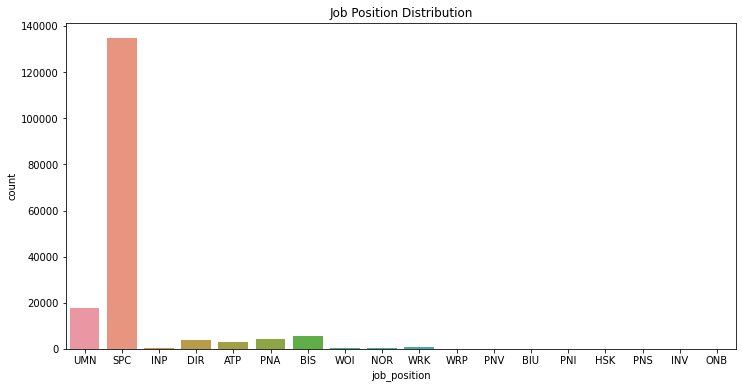

In [6]:
sparse_cat_columns =cat_info.index[-3:]

plt.figure(figsize=(12, 6))
plt.title('Job Position Distribution')
sns.countplot(data=data, x=sparse_cat_columns[0]);

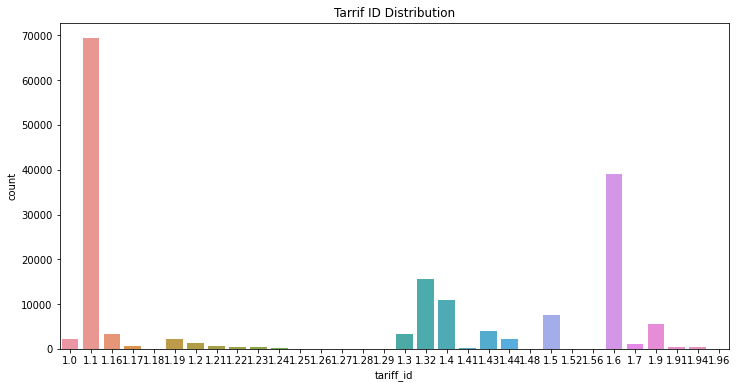

In [7]:
plt.figure(figsize=(12, 6))
plt.title('Tarrif ID Distribution')
sns.countplot(data=data, x=sparse_cat_columns[1]);

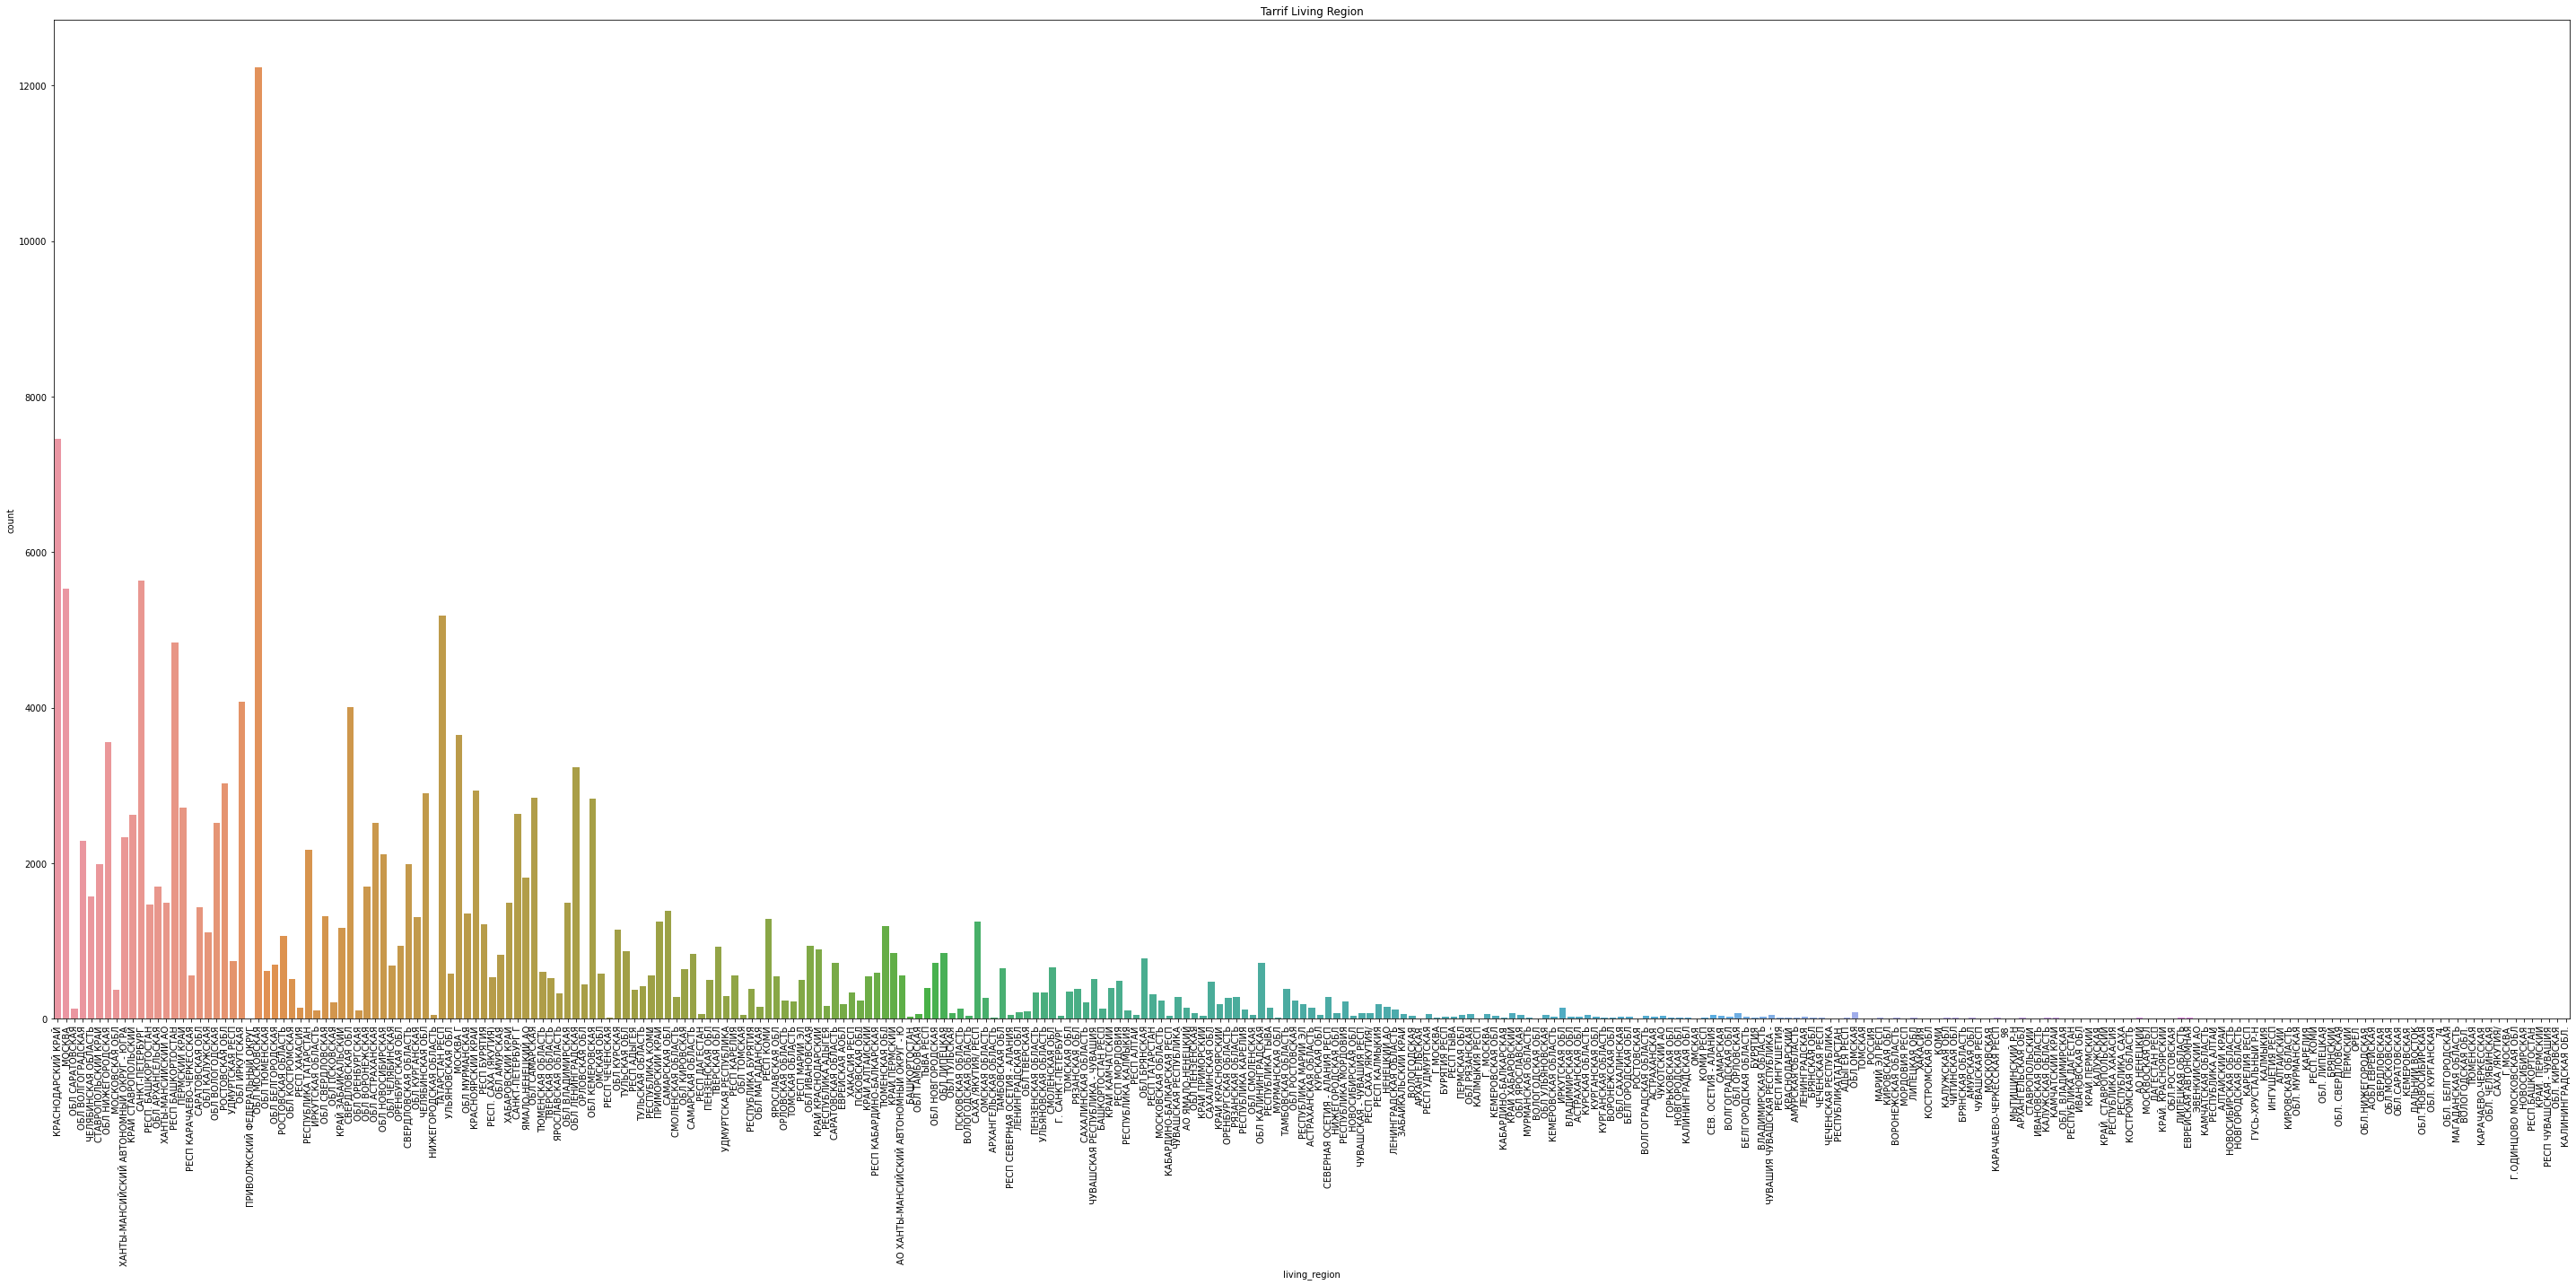

In [8]:
plt.figure(figsize=(40, 20))
plt.title('Tarrif Living Region')
plt.xticks(rotation=90)
sns.countplot(data=data, x=sparse_cat_columns[-1])
plt.tight_layout();

It can be observed that the features are indeed sparse! Especially `living_region`

### Sparse Categorical Features Preprocessing
**The strategy** - unite all rare categories in a new category called `OTHER`

In [9]:
data['job_position'].value_counts()

SPC    134680
UMN     17674
BIS      5591
PNA      4107
DIR      3750
ATP      2791
WRK       656
NOR       537
WOI       352
INP       241
BIU       126
WRP       110
PNI        65
PNV        40
PNS        12
HSK         8
INV         5
ONB         1
Name: job_position, dtype: int64

We define a thresholds - 100 observations. Each category that has less than 100 observations goes into a new category `OTHER`

In [10]:
# Process job_position
threshold = 100
jobs_cat_dist = data['job_position'].value_counts()
cat_to_unite = jobs_cat_dist[jobs_cat_dist <= threshold].index.to_list()

# Create new category OTHER
data['job_position'][data['job_position'].isin(cat_to_unite)] = 'OTHER'

In [11]:
# Process tariff_id
threshold = 100
tariff_cat_dist = data['tariff_id'].value_counts()
cat_to_unite = tariff_cat_dist[tariff_cat_dist <= threshold].index.to_list()

# Create new category 100
data['tariff_id'][data['tariff_id'].isin(cat_to_unite)] = 100

In [12]:
# Process living_region
threshold = 100
region_cat_dist = data['living_region'].value_counts()
cat_to_unite = region_cat_dist[region_cat_dist <= threshold].index.to_list()

# Create new category OTHER
data['living_region'][data['living_region'].isin(cat_to_unite)] = 'OTHER'

**let's look at the distributions again**

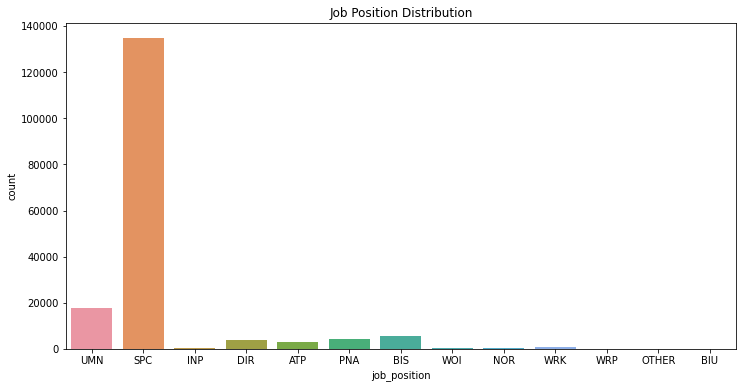

In [13]:
plt.figure(figsize=(12, 6))
plt.title('Job Position Distribution')
sns.countplot(data=data, x=sparse_cat_columns[0]);

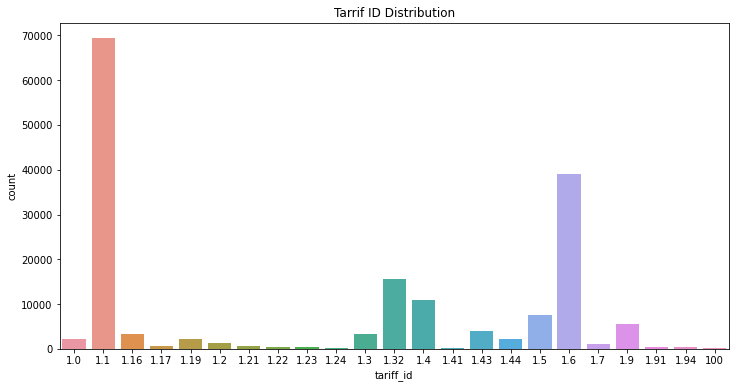

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Tarrif ID Distribution')
sns.countplot(data=data, x=sparse_cat_columns[1]);

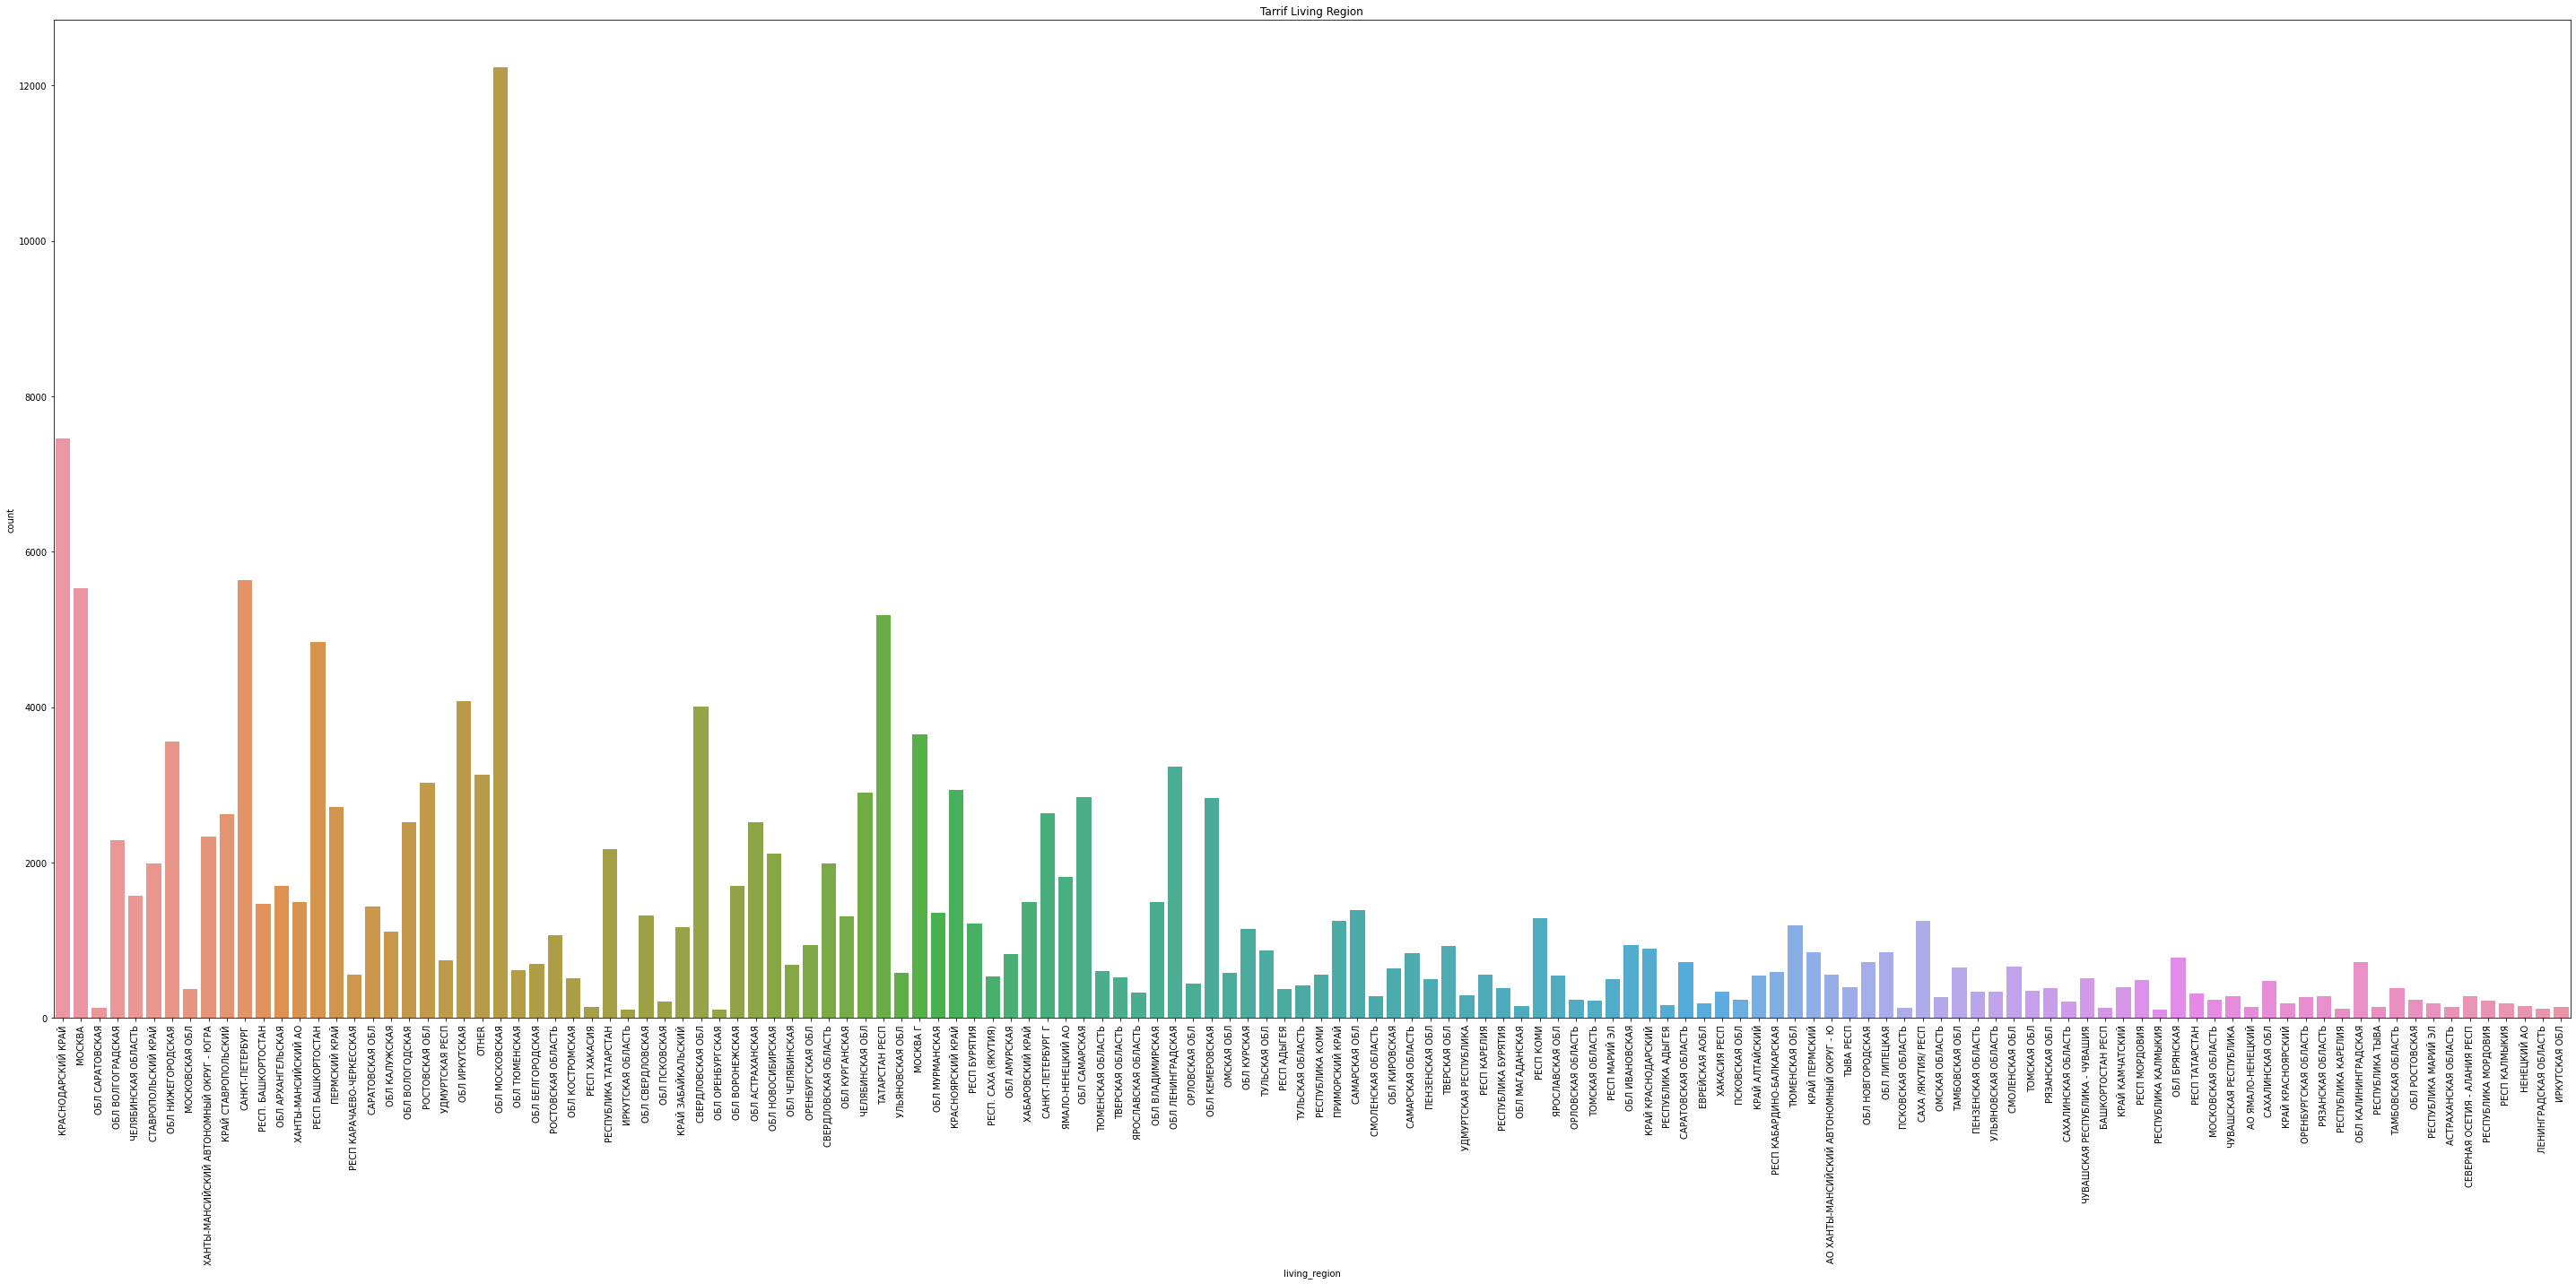

In [15]:
plt.figure(figsize=(40, 20))
plt.title('Tarrif Living Region')
plt.xticks(rotation=90)
sns.countplot(data=data, x=sparse_cat_columns[-1])
plt.tight_layout();

### Train/Test Split
If the distribution between train and test set is the same we expect to have a good model quality. However, in real world is not the case. 

Some problems that usually lead to higher test error:
- `Irrelevant Features` (don't have prior info about the features and their usefullness, complex model)
- `Not enough Relevant Features` (simple model)

In [16]:
train_data = data.sample(frac=0.7, random_state=23)
test_data = data.drop(train_data.index)

### Dealing with Missing Values
**After splitting the data into train and test** we can perform missing values imputation.

In [17]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Train Data Shape:  (119522, 14)
Test Data Shape:  (51224, 14)


In [18]:
# Train data missing values
train_data.isna().sum() / train_data.shape[0]

gender                 0.000
age                    0.000
marital_status         0.000
job_position           0.000
credit_sum             0.000
credit_month           0.000
tariff_id              0.000
score_shk              0.000
education              0.000
living_region          0.001
monthly_income         0.000
credit_count           0.054
overdue_credit_count   0.054
open_account_flg       0.000
dtype: float64

In [19]:
# Test data missing values
test_data.isna().sum() / test_data.shape[0]

gender                 0.000
age                    0.000
marital_status         0.000
job_position           0.000
credit_sum             0.000
credit_month           0.000
tariff_id              0.000
score_shk              0.000
education              0.000
living_region          0.001
monthly_income         0.000
credit_count           0.054
overdue_credit_count   0.054
open_account_flg       0.000
dtype: float64

**Most of the missing values can be dropped** because their fraction is small. Some of them don't exceed 1%, **except for:**
- `credit_count`
- `overdue_credit_count`

The main strategies for missing values imputation:
- Encoding (e.g. categorical - `missing/unknown`, continuous - `-999`)
- Using Statistics (e.g. mean, mode, median, etc) 
- Binary Feature where a values is missing (0/1)

These statistics must be computed **from train data and applied on test or can be computed indevidually (separately train and test)** 

All the techniques, except for Statistics, can be applied before splitting on train/test.

In [20]:
missing_data = data.isna().sum()
missing_columns = missing_data[missing_data != 0].index.to_list()

def fill_missing_data(df):
    impute_by_median = ['age', 'credit_sum', 'score_shk', 'monthly_income']
    for column in impute_by_median:
        df[column].fillna(train_data[column].median(), inplace=True) # test_data is imputed using train statistics
        
    inpute_by_value = ['credit_count', 'overdue_credit_count']
    for column in inpute_by_value:
        df[column].fillna(-1, inplace=True)
        
    inpute_by_mode = ['marital_status', 'education']
    for column in inpute_by_mode:
        df[column].fillna(data[column].mode()[0], inplace=True)
        
    df['living_region'].fillna('UNKNOWN', inplace=True)
    return df

In [21]:
# Fill missing data in train/test
train_data = fill_missing_data(train_data)
test_data = fill_missing_data(test_data)

print('N Missing Train: ', train_data.isna().sum().sum())
print('N Missing Train: ', test_data.isna().sum().sum())

N Missing Train:  0
N Missing Train:  0


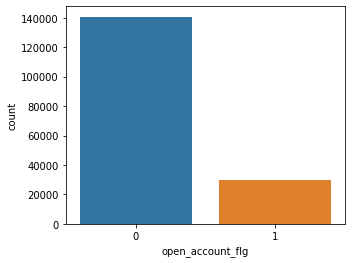

In [22]:
# Let's have a look at target classes distribution
plt.figure(figsize=(5, 4))
sns.countplot(data['open_account_flg']);

Most of the clients tend not to open a bank account. **Target classes are imbalanced**

### Baseline Model
Let's create a baseline model for the current data

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import roc_auc_score

TARGET_FEATURE_NAME = 'open_account_flg'

In [24]:
def split_features(df, target_col):
    """
    Splits features according to their type (e.g. numeric, binary and categorical)
    
    df: pd.DataFrame
        DataFrame with features
    target_name: str
        Name of the target feature
        
    Retruns: tuple
        Binary, Categorical and Numeric features
    """
    df = df.drop(columns=target_col)
    
    # Categorical and binary feature selection
    object_features_df = df.select_dtypes(['object', 'category']).describe()
    bin_features = object_features_df.columns[object_features_df.loc['unique'] == 2].to_list()
    cat_features = object_features_df.columns.difference(bin_features).to_list()
    
    # Numeric feature selection
    num_features = df.columns.difference(bin_features + cat_features).to_list()
    return bin_features, cat_features, num_features

In [26]:
# Split the features
bin_columns, cat_columns, num_columns = split_features(train_data, target_col=TARGET_FEATURE_NAME)

### Features Preprocessing

In [27]:
def encode_binary_features(df):
    """
    Encodes binary features by 0 and 1
    
    """
    for column in df.columns:
        values_to_encode = list(df[column].unique())
        df[column] = df[column].map({values_to_encode[0]: 0, values_to_encode[1]: 1})
    return df

# Numeric features scaling
def scale_num_features(df, scaler, scale_test=False):
    if not scale_test:
        num_features_scaled = scaler.fit_transform(df)
    else:
        num_features_scaled = scaler.transform(df)
        
    num_features_scaled = pd.DataFrame(num_features_scaled, index=df.index, columns=df.columns)
    return num_features_scaled, scaler

In [29]:
# Train Processing
target_train = train_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(train_data[bin_columns])
cat_features_enc = pd.get_dummies(train_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    train_data[num_columns],
    scale_test=False,
    scaler=RobustScaler()
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_train
]
train_data_enc = pd.concat(features_to_concat, axis='columns')

# Test Processing
target_test = test_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(test_data[bin_columns])
cat_features_enc = pd.get_dummies(test_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    test_data[num_columns],
    scale_test=True,
    scaler=fitted_scaler
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_test
]
test_data_enc = pd.concat(features_to_concat, axis='columns')

In [30]:
# Train/Test data
X_train = train_data_enc.drop(columns='open_account_flg')
y_train = train_data_enc['open_account_flg']

X_test = test_data_enc.drop(columns='open_account_flg')
y_test = test_data_enc['open_account_flg']

In [31]:
# Random Forest
forest_model = RandomForestClassifier(
    n_estimators=800,
    max_depth=17,
    random_state=23,
    n_jobs=-1
)

# Logistic Regression 
log_reg_model = LogisticRegression()

In [32]:
# Train the models
forest_model.fit(X_train, y_train)
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [33]:
# Random Forest predictions
forest_target_class_proba_train = forest_model.predict_proba(X_train)[:, 1]
forest_target_class_proba_test = forest_model.predict_proba(X_test)[:, 1]

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test)[:, 1]

# Metrics results
forest_auc_train = roc_auc_score(y_train, forest_target_class_proba_train)
forest_auc_test = roc_auc_score(y_test, forest_target_class_proba_test)

log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

In [34]:
print('ROC-AUC Random Forest Train: ', forest_auc_train)
print('ROC-AUC Random Forest Test: ', forest_auc_test)

print('\nROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Random Forest Train:  0.8497457144276179
ROC-AUC Random Forest Test:  0.7493950738681547

ROC-AUC Logistic Regression Train:  0.7220973758339921
ROC-AUC Logistic Regression Test:  0.7031528107135416


### Feature Engineering
let's try to improve the quality by creating/engineering new features

In [35]:
# Simple approach
def generate_new_features(df):
    # Tariff feature
    df['tariff_id'] = df['tariff_id'].astype('int')
        
    # Monthly credit sum
    df['monthly_credit_sum'] = df['credit_sum'] / df['credit_month']
    
    # Proportion of monthly credit sum to monthly income
    df['pmi'] = df['monthly_credit_sum'] / df['monthly_income']
    df['pmi'][df['pmi'] == np.inf] = 1
    
    # Squared features (probably useless for feature selection step)
    col_to_squre = ['tariff_id', 'age', 'credit_sum', 'score_shk', 'monthly_income', 'credit_month', 'credit_count']
    for column in col_to_squre:
        df[column + '_sq'] = df[column]**2
    return df

In [36]:
# New features generation
train_data = generate_new_features(train_data)
test_data = generate_new_features(test_data)

In [37]:
# Train Processing
target_train = train_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(train_data[bin_columns])
cat_features_enc = pd.get_dummies(train_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    train_data[num_columns],
    scale_test=False,
    scaler=RobustScaler()
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_train
]
train_data_enc = pd.concat(features_to_concat, axis='columns')

# Test Processing
target_test = test_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(test_data[bin_columns])
cat_features_enc = pd.get_dummies(test_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    test_data[num_columns],
    scale_test=True,
    scaler=fitted_scaler
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_test
]
test_data_enc = pd.concat(features_to_concat, axis='columns')

In [38]:
# Train/Test data
X_train = train_data_enc.drop(columns='open_account_flg')
y_train = train_data_enc['open_account_flg']

X_test = test_data_enc.drop(columns='open_account_flg')
y_test = test_data_enc['open_account_flg']

In [39]:
# Train the models
forest_model.fit(X_train, y_train)
log_reg_model.fit(X_train, y_train)

# Random Forest predictions
forest_target_class_proba_train = forest_model.predict_proba(X_train)[:, 1]
forest_target_class_proba_test = forest_model.predict_proba(X_test)[:, 1]

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test)[:, 1]

# Metrics results
forest_auc_train = roc_auc_score(y_train, forest_target_class_proba_train)
forest_auc_test = roc_auc_score(y_test, forest_target_class_proba_test)

log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Random Forest Train: ', forest_auc_train)
print('ROC-AUC Random Forest Test: ', forest_auc_test)

print('\nROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Random Forest Train:  0.8058778368223279
ROC-AUC Random Forest Test:  0.6777940902952844

ROC-AUC Logistic Regression Train:  0.6574355837182883
ROC-AUC Logistic Regression Test:  0.6338656978561146


Quality has dropped down. This is due to the fact that we have created features that are useless. As a result **the model is complex and overfits train data.**

### Other Feature Engineering Techniques
### Data enrichment



In [40]:
# Data enrichment
unique_jobs = train_data['job_position'].unique()

# Let's assume that we have data source where avg salary is known for each job position
avg_income = {'SPC': 63000, 'UMN': 51000, 'PNA': 71000, 'BIS': 86000,
              'ATP': 46000, 'WRK': 77000, 'NOR': 54000, 'DIR': 60000,
              'INP': 55000, 'BIU': 43000, 'WOI': 76000, 'WRP': 75000, 'OTHER': 20000}

# According to data above we can create a new feature calles avg_income
train_data['job_position'].map(avg_income).head()

41202     63000
157836    63000
113314    63000
158150    63000
122652    51000
Name: job_position, dtype: int64

### Categorical Features Encoding 
A categorical feature with many categories can be encoded by a number of observations per category.

It is especially good for tree-based algorithms.

Many categories introduce many options for a split in a tree (e.g. 33 categories introduce 4 million possible options for a split)

### Frequency Encoding

In [41]:
# let's encode sparse categorical feature 'living_region' into a new feature 'region_cnt'
train_data['living_region'].map(train_data['living_region'].value_counts())

41202     1957
157836    3903
113314    8575
158150     211
122652    8575
          ... 
65590     1833
16011       96
41626      397
16957      393
29204     1523
Name: living_region, Length: 119522, dtype: int64

### Mean Category Encoding
Each category is incoded by a statistic (mean, median, ...) computed on numeric feature that fall in the category 

In [42]:
# Define a function for category encoding 
def encode_category(df, cat_feature, num_feature, statistic='mean'):
    if statistic == 'mean':
        cat_statistic = df.groupby(cat_feature)[num_feature].mean()
    return df[cat_feature].map(cat_statistic)

In [43]:
encode_category(
    train_data,
    cat_feature='living_region',
    num_feature='monthly_income',
    statistic='mean'
)

41202    31615.491
157836   50710.845
113314   53123.428
158150   26626.540
122652   53123.428
            ...   
65590    49684.836
16011    65623.958
41626    36515.884
16957    45505.089
29204    35669.669
Name: living_region, Length: 119522, dtype: float64

### Numeric Encoding 
Mean value of **several features**

In [44]:
# Select age and credit_month
train_data[['age', 'credit_month']].mean(axis='columns')

41202    28.500
157836   21.000
113314   25.500
158150   30.000
122652   20.500
          ...  
65590    21.500
16011    26.000
41626    21.000
16957    25.000
29204    21.500
Length: 119522, dtype: float64

In [45]:
# Can create a new binary featurere retired
np.where(train_data['age'] >= 60, 'yes', 'no')

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype='<U3')

### Binning 
Numeric feature can be binned (split into groups - new intervals). Binning is used **when a feature is not linearly dependent with the target** 

However, this approach has several drawbacks:
- Feature lose its power (has less info)

In [46]:
# let's bin monthly_income feature using 3 category
bins = [-np.inf, 50000, 200000, np.inf]
bin_names = ['low_income', 'avg_income', 'high_income']
pd.cut(train_data['monthly_income'], bins=bins, labels=bin_names)

41202     low_income
157836    low_income
113314    low_income
158150    low_income
122652    avg_income
             ...    
65590     low_income
16011     avg_income
41626     low_income
16957     low_income
29204     low_income
Name: monthly_income, Length: 119522, dtype: category
Categories (3, object): ['low_income' < 'avg_income' < 'high_income']

In [47]:
# let's bin using decile
pd.qcut(train_data['monthly_income'], q=10)

41202      (26600.0, 30000.0]
157836     (30000.0, 35000.0]
113314     (26600.0, 30000.0]
158150     (26600.0, 30000.0]
122652     (50000.0, 67000.0]
                 ...         
65590      (35000.0, 40000.0]
16011     (67000.0, 950000.0]
41626      (26600.0, 30000.0]
16957      (35000.0, 40000.0]
29204      (45000.0, 50000.0]
Name: monthly_income, Length: 119522, dtype: category
Categories (10, interval[float64]): [(5599.999, 20000.0] < (20000.0, 24000.0] < (24000.0, 26600.0] < (26600.0, 30000.0] ... (40000.0, 45000.0] < (45000.0, 50000.0] < (50000.0, 67000.0] < (67000.0, 950000.0]]